<a href="https://colab.research.google.com/github/husnanzzry/FYP_Degree/blob/main/LSTM_Model_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib-venn

In [ ]:
!pip install tensorflow

In [ ]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from numpy.random import seed
seed(2899)
tf.random.set_seed(99)
from sklearn.model_selection import train_test_split

In [ ]:
import keras

In [ ]:
from keras.models import Sequential

In [ ]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
import keras
from keras.layers import Dense, Activation, Dropout, Reshape, Permute
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Importing dataset

dataset = pd.read_csv("extractsentiment_vader.csv")

In [ ]:
dataset.shape

(11624, 3)

In [ ]:
dataset.head(5)

,text_lemmatized,Score,Sentiment
0,best use maybank app apps run smoothly money m...,1.269231,Positive
1,must malicious apps phone ask change phone upd...,0.282051,Positive
2,service bsn problem news daily light make mybs...,0.205128,Positive
3,maybank apps statement 1 green 99 red,0.000000,Negative
4,something wrong maybank mae apps,-0.538462,Negative


<Axes: xlabel='Sentiment', ylabel='count'>

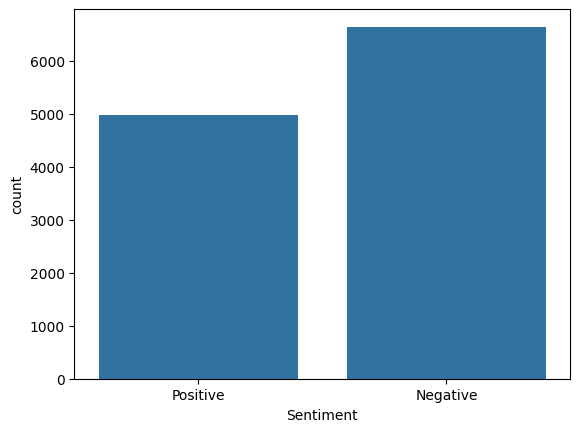

In [ ]:
import seaborn as sns
sns.countplot(x='Sentiment', data=dataset)

<Axes: xlabel='Sentiment', ylabel='count'>

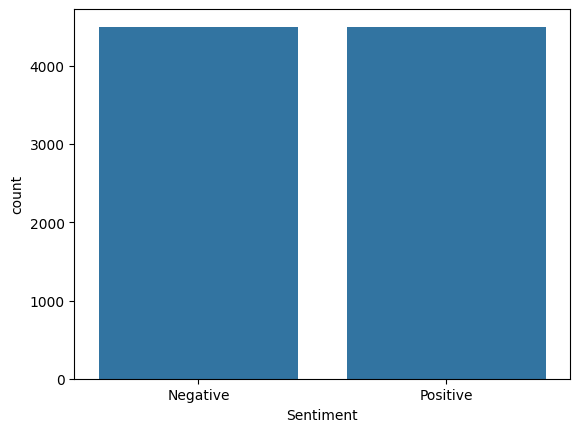

In [ ]:
# Get "Positive" and "Negative" samples
positive_samples = dataset[dataset['Sentiment'] == "Positive"]
negative_samples = dataset[dataset['Sentiment'] == "Negative"]

# Randomly select 4500 samples from each
positive_samples = positive_samples.sample(n=4500, random_state=42)
negative_samples = negative_samples.sample(n=4500, random_state=42)

# Combine the samples
balanced_dataset = pd.concat([positive_samples, negative_samples])

# Shuffle the dataset
dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='Sentiment', data=dataset)

In [ ]:
X = dataset['text_lemmatized']

y = dataset['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))


In [ ]:
X.shape

(9000,)

**SPLIT 70-30**

In [ ]:
# First split to get training+validation (70%) and test sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training+validation set into training (60%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/7, random_state=42, stratify=y_train_val)

# The test_size=1/7 ensures that the validation set is approximately 10% of the original dataset
# and the training set is approximately 60% of the original dataset.


In [ ]:
X_train.shape

(5400,)

In [ ]:
X_val.shape

(900,)

In [ ]:
X_test.shape

(2700,)

PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7391

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(7391, 100)

In [ ]:
X_train.shape

(5400, 100)

In [ ]:
X_val.shape

(900, 100)

In [ ]:
X_test.shape

(2700, 100)

**LSTM MODEL 1**

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model1 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model1.add(embedding_layer)
lstm_model1.add(LSTM(128))
lstm_model1.add(Dense(50, activation='sigmoid'))

lstm_model1.add(Dense(1, activation='sigmoid'))



In [ ]:
# Model compiling
lstm_model1.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model1.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          739100    
                                                                 
 lstm_6 (LSTM)               (None, 128)               117248    
                                                                 
 dense_9 (Dense)             (None, 50)                6450      
                                                                 
 dense_10 (Dense)            (None, 1)                 51        
                                                                 
Total params: 862849 (3.29 MB)
Trainable params: 123749 (483.39 KB)
Non-trainable params: 739100 (2.82 MB)
_________________________________________________________________
None


In [ ]:
# Model training
lstm_model1_history = lstm_model1.fit(X_train, y_train, batch_size=4000, epochs=50, verbose=1, validation_data=(X_val,y_val))

Epoch 1/50
2/2 [==============================] - 18s 4s/step - loss: 0.7991 - accuracy: 0.5000 - val_loss: 0.7866 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 11s 3s/step - loss: 0.7846 - accuracy: 0.5000 - val_loss: 0.7718 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 11s 5s/step - loss: 0.7693 - accuracy: 0.5000 - val_loss: 0.7537 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 10s 3s/step - loss: 0.7501 - accuracy: 0.5000 - val_loss: 0.7228 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 11s 3s/step - loss: 0.7146 - accuracy: 0.5000 - val_loss: 0.7185 - val_accuracy: 0.5033
Epoch 6/50
2/2 [==============================] - 12s 4s/step - loss: 0.7082 - accuracy: 0.5039 - val_loss: 0.6747 - val_accuracy: 0.6189
Epoch 7/50
2/2 [==============================] - 11s 4s/step - loss: 0.6741 - accuracy: 0.6404 - val_loss: 0.6713 - val_accuracy: 0.6589
Epoch 8/50
2/2 [==================

In [ ]:

# Predictions on the Test Set

score_lstm_model1= lstm_model1.evaluate(X_test, y_test, verbose=1)

85/85 [==============================] - 5s 58ms/step - loss: 0.3973 - accuracy: 0.8333


In [ ]:
print("Test Accuracy: %.2f%%" % (score_lstm_model1[1]*100))
print("Test Loss: %.2f%%" % (score_lstm_model1[0]*100))

Test Accuracy: 83.33%
Test Loss: 39.73%


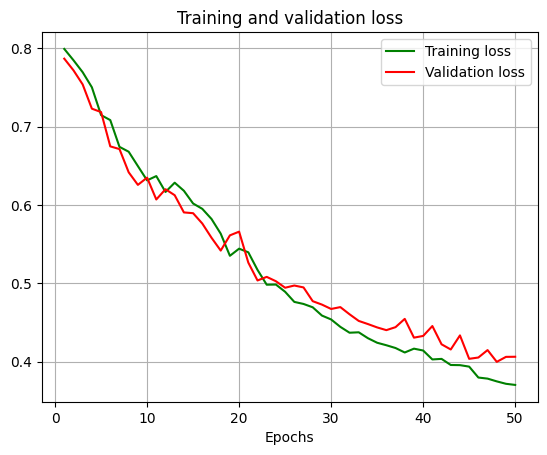

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model1_history.history['loss']
val_loss = lstm_model1_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

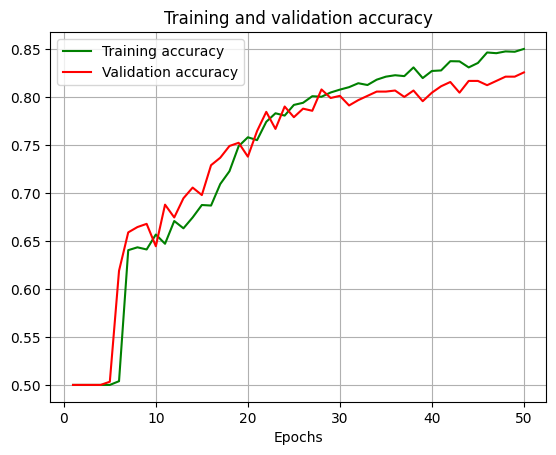

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model1_history.history['accuracy']
val_loss = lstm_model1_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

85/85 [==============================] - 5s 56ms/step


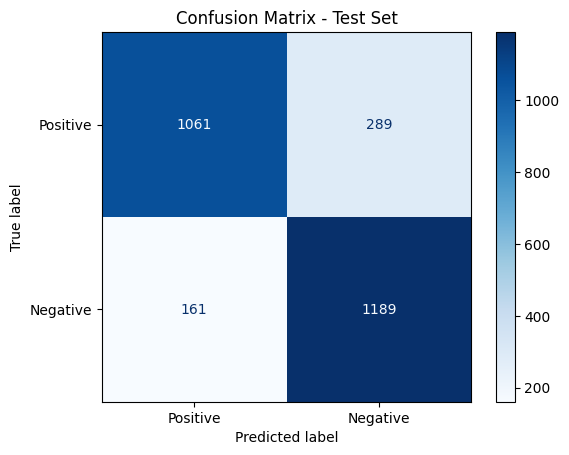

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = lstm_model1.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.87      0.79      0.83      1350
    Positive       0.80      0.88      0.84      1350

    accuracy                           0.83      2700
   macro avg       0.84      0.83      0.83      2700
weighted avg       0.84      0.83      0.83      2700



**CNN MODEL 2**

<Axes: xlabel='Sentiment', ylabel='count'>

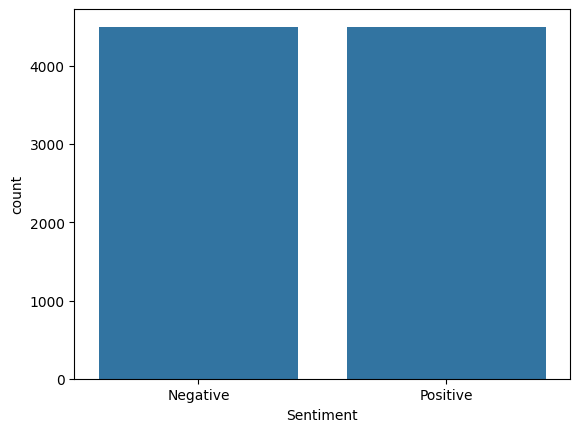

In [ ]:
# Get "Positive" and "Negative" samples
positive_samples = dataset[dataset['Sentiment'] == "Positive"]
negative_samples = dataset[dataset['Sentiment'] == "Negative"]

# Randomly select 4500 samples from each
positive_samples = positive_samples.sample(n=4500, random_state=42)
negative_samples = negative_samples.sample(n=4500, random_state=42)

# Combine the samples
balanced_dataset = pd.concat([positive_samples, negative_samples])

# Shuffle the dataset
dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='Sentiment', data=dataset)

In [ ]:
X = dataset['text_lemmatized']

y = dataset['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))


In [ ]:
# First split to get training+validation (70%) and test sets (30%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split the training+validation set into training (60%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/7, random_state=42, stratify=y_train_val)

# The test_size=1/7 ensures that the validation set is approximately 10% of the original dataset
# and the training set is approximately 60% of the original dataset.


PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7308

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

lstm_model2 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model2.add(embedding_layer)
lstm_model2.add(LSTM(128))
#lstm_model2.add(Dense(100, activation='sigmoid'))
lstm_model2.add(Dense(10, activation='sigmoid'))
lstm_model2.add(Dense(1, activation='sigmoid'))



In [ ]:
# Model co.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model2.summary())
mpiling
lstm_model2

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          730800    
                                                                 
 lstm_12 (LSTM)              (None, 128)               117248    
                                                                 
 dense_28 (Dense)            (None, 10)                1290      
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 849349 (3.24 MB)
Trainable params: 118549 (463.08 KB)
Non-trainable params: 730800 (2.79 MB)
_________________________________________________________________
None


In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

lstm_model2_history = lstm_model2.fit(X_train, y_train, batch_size=4000, epochs=100, verbose=1, validation_data=(X_val,y_val))

Epoch 1/100
2/2 [==============================] - 15s 6s/step - loss: 0.7117 - accuracy: 0.5000 - val_loss: 0.7095 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 12s 4s/step - loss: 0.7091 - accuracy: 0.5000 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 12s 4s/step - loss: 0.7059 - accuracy: 0.5000 - val_loss: 0.7024 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 13s 4s/step - loss: 0.7012 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 14s 5s/step - loss: 0.6912 - accuracy: 0.5270 - val_loss: 0.6703 - val_accuracy: 0.5600
Epoch 6/100
2/2 [==============================] - 11s 4s/step - loss: 0.6571 - accuracy: 0.5904 - val_loss: 0.6782 - val_accuracy: 0.6011
Epoch 7/100
2/2 [==============================] - 11s 3s/step - loss: 0.6570 - accuracy: 0.6254 - val_loss: 0.6608 - val_accuracy: 0.6322
Epoch 8/100
2/2 [==========

In [ ]:

# Predictions on the Test Set

score_lstm_model2= lstm_model2.evaluate(X_test, y_test, verbose=1)

85/85 [==============================] - 5s 57ms/step - loss: 0.3932 - accuracy: 0.8515


In [ ]:
print("Test Accuracy: %.2f%%" % (score_lstm_model2[1]*100))
print("Test Loss: %.2f%%" % (score_lstm_model2[0]*100))

Test Accuracy: 85.15%
Test Loss: 39.32%


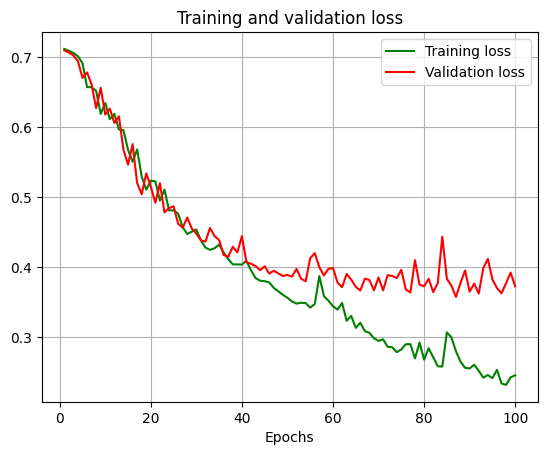

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model2_history.history['loss']
val_loss = lstm_model2_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

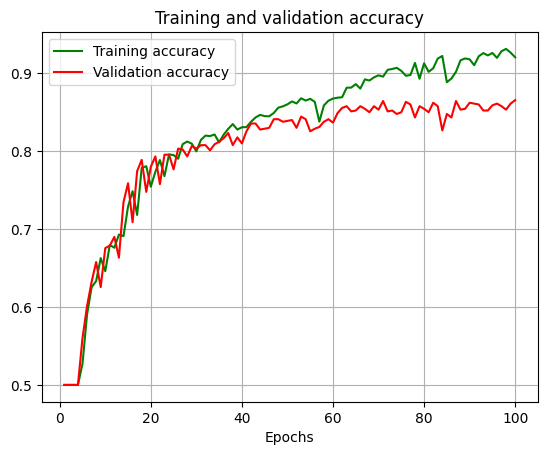

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model2_history.history['accuracy']
val_loss = lstm_model2_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

85/85 [==============================] - 5s 53ms/step


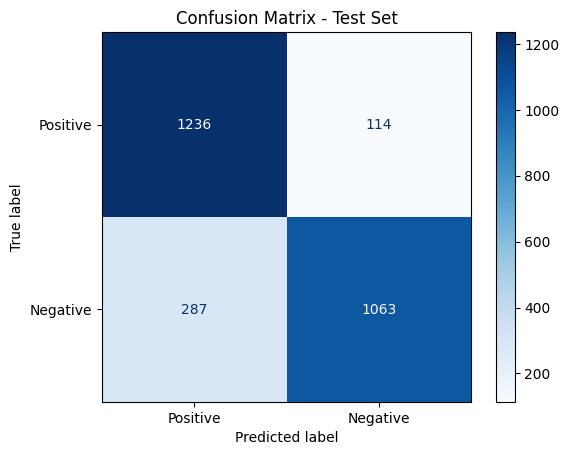

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = lstm_model2.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.81      0.92      0.86      1350
    Positive       0.90      0.79      0.84      1350

    accuracy                           0.85      2700
   macro avg       0.86      0.85      0.85      2700
weighted avg       0.86      0.85      0.85      2700



**SPLIT 80-20**

**LSTM MODEL 3**

In [ ]:
from sklearn.model_selection import train_test_split

# First split to get training+validation (80%) and test sets (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# The test_size=0.125 ensures that the validation set is approximately 10% of the original dataset
# because 0.125 of 80% is 10%.


In [ ]:
X_train.shape

(6300,)

In [ ]:
X_val.shape

(900,)

In [ ]:
X_test.shape

(1800,)

PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

7957

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(7957, 100)

In [ ]:
X_train.shape

(6300, 100)

In [ ]:
X_val.shape

(900, 100)

In [ ]:
X_test.shape

(1800, 100)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model3 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model3.add(embedding_layer)
lstm_model3.add(LSTM(128))
lstm_model3.add(Dense(50, activation='sigmoid'))
lstm_model3.add(Dense(1, activation='sigmoid'))



In [ ]:
# Model compiling
lstm_model3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model3.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          795700    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 50)                6450      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 919449 (3.51 MB)
Trainable params: 123749 (483.39 KB)
Non-trainable params: 795700 (3.04 MB)
_________________________________________________________________
None


In [ ]:
# Model training
lstm_model3_history = lstm_model3.fit(X_train, y_train, batch_size=4000, epochs=50, verbose=1, validation_data=(X_val,y_val))

Epoch 1/50
2/2 [==============================] - 35s 13s/step - loss: 0.7980 - accuracy: 0.5000 - val_loss: 0.7868 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 17s 5s/step - loss: 0.7842 - accuracy: 0.5000 - val_loss: 0.7726 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 12s 4s/step - loss: 0.7700 - accuracy: 0.5000 - val_loss: 0.7567 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 13s 4s/step - loss: 0.7533 - accuracy: 0.5000 - val_loss: 0.7337 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 13s 5s/step - loss: 0.7266 - accuracy: 0.5000 - val_loss: 0.6827 - val_accuracy: 0.5544
Epoch 6/50
2/2 [==============================] - 13s 6s/step - loss: 0.6772 - accuracy: 0.5683 - val_loss: 0.6358 - val_accuracy: 0.6478
Epoch 7/50
2/2 [==============================] - 12s 5s/step - loss: 0.6400 - accuracy: 0.6437 - val_loss: 0.6306 - val_accuracy: 0.6633
Epoch 8/50
2/2 [=================

In [ ]:

# Predictions on the Test Set

score_lstm_model3= lstm_model3.evaluate(X_test, y_test, verbose=1)

57/57 [==============================] - 4s 60ms/step - loss: 0.4083 - accuracy: 0.8200


In [ ]:
print("Test Accuracy: %.2f%%" % (score_lstm_model3[1]*100))
print("Test Loss: %.2f%%" % (score_lstm_model3[0]*100))

Test Accuracy: 82.00%
Test Loss: 40.83%


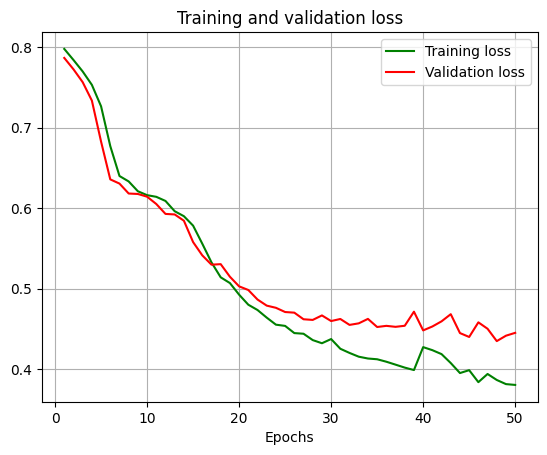

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model3_history.history['loss']
val_loss = lstm_model3_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

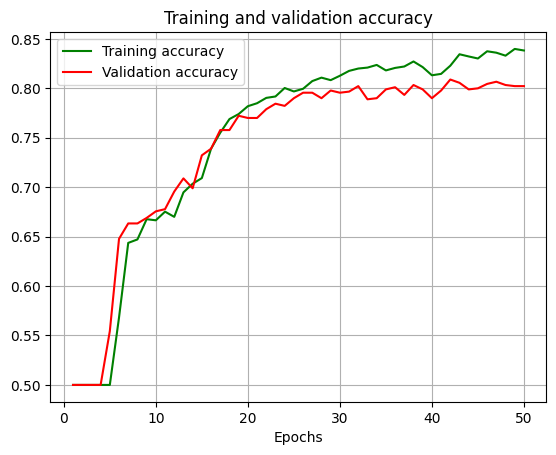

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model3_history.history['accuracy']
val_loss = lstm_model3_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

57/57 [==============================] - 4s 56ms/step


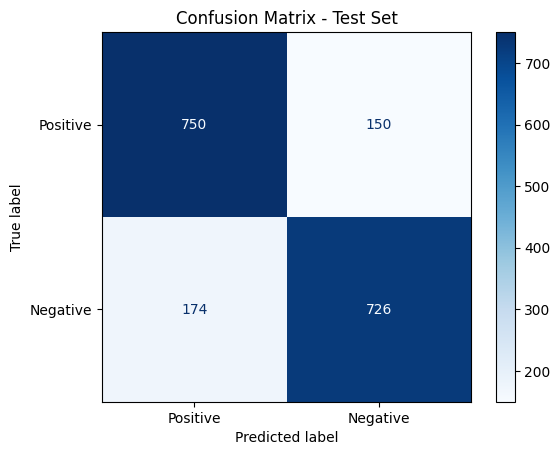

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = lstm_model3.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.81      0.83      0.82       900
    Positive       0.83      0.81      0.82       900

    accuracy                           0.82      1800
   macro avg       0.82      0.82      0.82      1800
weighted avg       0.82      0.82      0.82      1800



**CNN MODEL 4**

<Axes: xlabel='Sentiment', ylabel='count'>

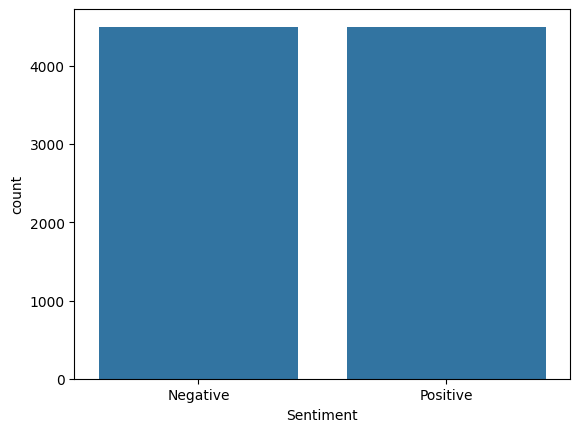

In [ ]:
# Get "Positive" and "Negative" samples
positive_samples = dataset[dataset['Sentiment'] == "Positive"]
negative_samples = dataset[dataset['Sentiment'] == "Negative"]

# Randomly select 4500 samples from each
positive_samples = positive_samples.sample(n=4500, random_state=42)
negative_samples = negative_samples.sample(n=4500, random_state=42)

# Combine the samples
balanced_dataset = pd.concat([positive_samples, negative_samples])

# Shuffle the dataset
dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='Sentiment', data=dataset)

In [ ]:
X = dataset['text_lemmatized']

y = dataset['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="Positive" else 0, y)))


In [ ]:
from sklearn.model_selection import train_test_split

# First split to get training+validation (80%) and test sets (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split the training+validation set into training (70%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

# The test_size=0.125 ensures that the validation set is approximately 10% of the original dataset
# because 0.125 of 80% is 10%.


PREPARING EMBEDDING LAYER

In [ ]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_val = word_tokenizer.texts_to_sequences(X_val)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [ ]:
import io
import json

In [ ]:
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

8057

In [ ]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:

# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

lstm_model4 = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model4.add(embedding_layer)
lstm_model4.add(LSTM(128))
lstm_model4.add(Dense(50, activation='sigmoid'))
lstm_model4.add(Dense(1, activation='sigmoid'))



In [ ]:
# Model compiling
lstm_model4.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
print(lstm_model4.summary())


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          805700    
                                                                 
 lstm_14 (LSTM)              (None, 128)               117248    
                                                                 
 dense_32 (Dense)            (None, 50)                6450      
                                                                 
 dense_33 (Dense)            (None, 1)                 51        
                                                                 
Total params: 929449 (3.55 MB)
Trainable params: 123749 (483.39 KB)
Non-trainable params: 805700 (3.07 MB)
_________________________________________________________________
None


In [ ]:
# Model training
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping

lstm_model4_history = lstm_model4.fit(X_train, y_train, batch_size=4000, epochs=100, verbose=1, validation_data=(X_val,y_val))

Epoch 1/100
2/2 [==============================] - 98s 5s/step - loss: 0.7211 - accuracy: 0.5000 - val_loss: 0.7152 - val_accuracy: 0.5000
Epoch 2/100
2/2 [==============================] - 13s 4s/step - loss: 0.7139 - accuracy: 0.5000 - val_loss: 0.7083 - val_accuracy: 0.5000
Epoch 3/100
2/2 [==============================] - 12s 5s/step - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.7014 - val_accuracy: 0.5000
Epoch 4/100
2/2 [==============================] - 13s 7s/step - loss: 0.7003 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 12s 6s/step - loss: 0.6945 - accuracy: 0.4975 - val_loss: 0.6933 - val_accuracy: 0.5022
Epoch 6/100
2/2 [==============================] - 12s 5s/step - loss: 0.6937 - accuracy: 0.5003 - val_loss: 0.6922 - val_accuracy: 0.5044
Epoch 7/100
2/2 [==============================] - 12s 4s/step - loss: 0.6927 - accuracy: 0.5006 - val_loss: 0.6921 - val_accuracy: 0.5044
Epoch 8/100
2/2 [==========

In [ ]:

# Predictions on the Test Set

score_lstm_model4= lstm_model4.evaluate(X_test, y_test, verbose=1)

57/57 [==============================] - 3s 57ms/step - loss: 0.3767 - accuracy: 0.8500


In [ ]:
print("Test Accuracy: %.2f%%" % (score_lstm_model4[1]*100))
print("Test Loss: %.2f%%" % (score_lstm_model4[0]*100))

Test Accuracy: 85.00%
Test Loss: 37.67%


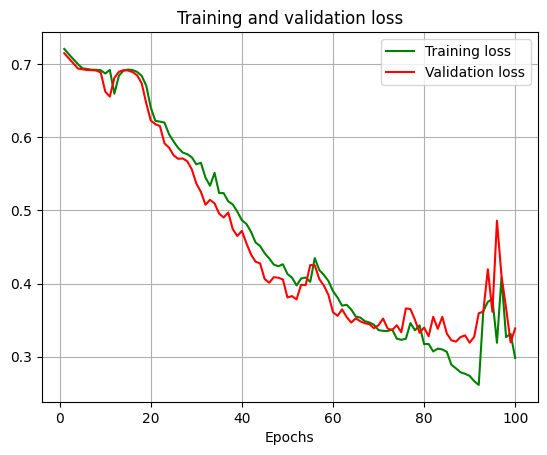

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model4_history.history['loss']
val_loss = lstm_model4_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

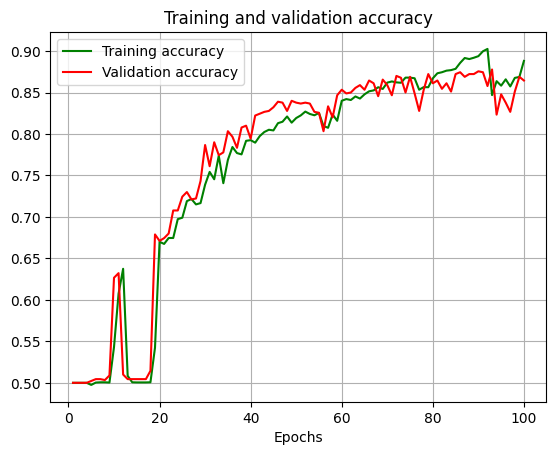

In [ ]:
from matplotlib import pyplot as plt
loss = lstm_model4_history.history['accuracy']
val_loss = lstm_model4_history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.grid()
plt.show()

57/57 [==============================] - 4s 54ms/step


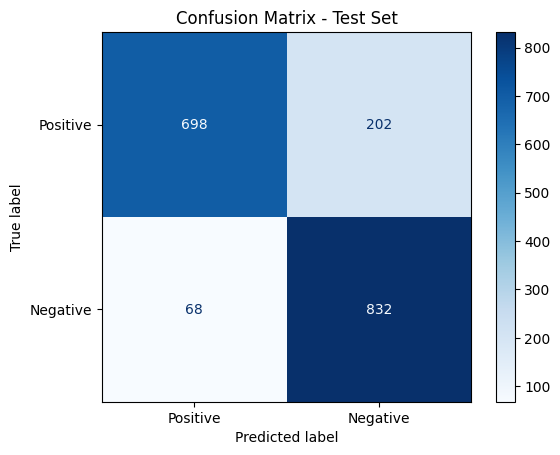

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions for the test sets
y_true = lstm_model4.predict(X_test)

# Convert probabilities to binary labels
y_true = (y_true > 0.5).astype(int)

# Compute confusion matrices
cm_test = confusion_matrix(y_test, y_true)

# Display the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Positive', 'Negative'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Print classification report for the test set
print("Classification Report")
print(classification_report(y_test, y_true, target_names=['Negative', 'Positive']))

Classification Report
              precision    recall  f1-score   support

    Negative       0.91      0.78      0.84       900
    Positive       0.80      0.92      0.86       900

    accuracy                           0.85      1800
   macro avg       0.86      0.85      0.85      1800
weighted avg       0.86      0.85      0.85      1800

